In [1]:
# Import all the utilities libraries as needed.
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn
from ipywidgets import IntProgress

# Import linear regression libraries.
from sklearn.linear_model import LogisticRegression

# Import torch as the main neural network framework.
import torch
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm


In [2]:
# Load in the AlexNet pretrained model from pytorch.
alex_net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\alisa/.cache\torch\hub\pytorch_vision_v0.6.0


In [3]:
# Define transform for the input data into the pre-trained model's dimension expectations.
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## <span style='color:Green'> Part A.  </span>

In [4]:
# Download the training and testing dataset from the torch data library.
train_dataset = CIFAR10(root='data/', download=True, transform=data_transform)
test_dataset = CIFAR10(root='data/', train=False, transform=data_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [5]:
# Split the training data into training and validation sets.
# Randomize the data and load 40,000 training images, and 10,000 validation images.
torch.manual_seed(69)
training_data, validation_data = torch.utils.data.random_split(train_dataset, [40000,10000])

In [6]:
# Extract the classes contained within the data.
classes = train_dataset.classes


In [7]:
# Define a function for printing the image and the label.
def display_image(image, label):
    plt.imshow(image.permute(1,2,0))
    print("Label: ",classes[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  cat


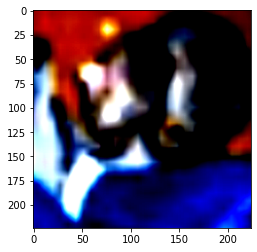

In [8]:
# Test the display image function.
display_image(*test_dataset[0])

## <span style='color:Green'> Part B.  </span>

In [9]:
# Construct the dataloaders for all three sets of data.
batch_size = 1
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4)

In [10]:
# Add all the AlexNet predictions for the test data into a list.
alex_pred_list = []
with torch.no_grad():
    for data in tqdm(test_loader):
        # Get all possible predictions.
        image = data[0]
        pred = alex_net(image)

        # Get best possibility and add it to list.
        _, alex_pred = torch.max(pred, 1)
        alex_pred_list.append(alex_pred.item())

100%|██████████████████████████████████████████████████| 10000/10000 [05:45<00:00, 28.95it/s]


In [11]:
# Get the number of instances of each label in the prediction list.
instance_list = []
top_ten_pred = []
for i in range(1000):
    instances = alex_pred_list.count(i)
    element = [i, instances]
    instance_list.append(element)
    
# Sort the instance list to get the top 10 predictions.
instance_list.sort(reverse=True, key=operator.itemgetter(1))
top_ten_elem = instance_list[:10]

# Get the top 10 predictions.
top_ten_pred = [ i[0] for i in top_ten_elem ]
print(top_ten_pred)

[675, 335, 339, 510, 167, 653, 856, 152, 194, 491]


In [12]:
# Sort the top ten predictions in ascending order of indicies.
top_ten_pred.sort()

# Using the indicies obtained above, the corresponding predictions in the ImageNet test-bank are as follows.
image_net_pred = ['Japanese spaniel',
                  'English foxhound',
                  'Dandie Dinmont, Dandie Dinmont terrier',
                  'fox squirrel, eastern fox squirrel, Sciurus niger',
                  'sorrel',
                  'chain saw, chainsaw',
                  'container ship, containership, container vessel',
                  'milk can',
                  'moving van',
                  'thresher, thrasher, threshing machine']

In [13]:
# Construct the confusion matrix setup.
confusion_mat = np.zeros((10,10),dtype=int)
data_index = 0

# Loop through test data and see how many labels fit the top-10.
for data in test_loader:
    label_index = data[1].item()
    for pred in top_ten_pred:
        
        # If the labels match then increment the matrix value.
        if (pred == alex_pred_list[data_index]):
            confusion_mat[label_index][top_ten_pred.index(pred)] += 1
    
    # Increment the counter variable for the outer for-loop.
    data_index += 1

<AxesSubplot:>

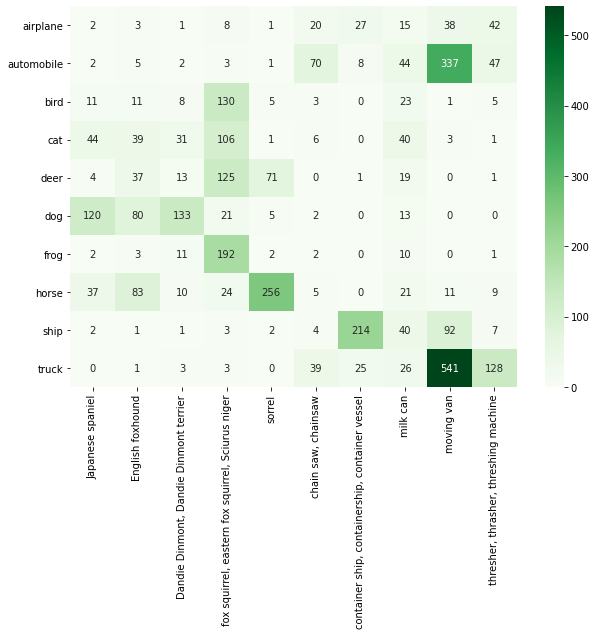

In [14]:
# Plot the confusion matrix.
confusion_mat_plot = pd.DataFrame(confusion_mat, index = [class_ for class_ in classes],
                  columns = [pred for pred in image_net_pred])
plt.figure(figsize = (10,7))
seaborn.heatmap(confusion_mat_plot, annot=True,fmt='d', cmap="Greens")


## <span style='color:Green'> Part C.  </span>

In [15]:
# Evaluation of the AlexNet model shows that the fc6 layer is at index 1.
# alex_net.eval()

# Thus for extracting the fc6 layer features, we need to cut off the classifier at this layer and construct a new model.
fc6_alex = alex_net
fc6_alex_classifier = torch.nn.Sequential(*list(alex_net.classifier.children())[:-5])
fc6_alex.classifier = fc6_alex_classifier

# Show the resulting model.
fc6_alex.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
# Evaluate the training data predictions given by the fc6 model.
# Use 5000 images to run the algorithm tuning for figuring out the best C value.
fc6_alex_train_x_5k = []
fc6_alex_train_y_5k = []

# Use all 40,000 images to fit the model with after figuring out the best C value.
fc6_alex_train_x_40k = []
fc6_alex_train_y_40k = []

# Set the counter to obtain only 5000 images for the tuning.
count = 0

with torch.no_grad():
    for data in tqdm(training_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc6_alex(image)

        fc6_alex_train_x_40k.append(pred.numpy())
        fc6_alex_train_y_40k.append(label.item())
        
        # Stop populating once 5000 images have been collected.
        if (count <= 4999):
            fc6_alex_train_x_5k.append(pred.numpy())
            fc6_alex_train_y_5k.append(label.item())
        
        count += 1

100%|██████████████████████████████████████████████████| 40000/40000 [17:26<00:00, 38.24it/s]


In [17]:
# Retrieve the validation sets data given by the fc6 model.
fc6_alex_val_x = []
fc6_alex_val_y = []

with torch.no_grad():
    for data in tqdm(validation_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc6_alex(image)

        fc6_alex_val_x.append(pred.numpy())
        fc6_alex_val_y.append(label.item())

100%|██████████████████████████████████████████████████| 10000/10000 [04:27<00:00, 37.31it/s]


In [18]:
# Need to flatten the elments into a 1D list.
fc6_alex_train_x_5k_flat = []
fc6_alex_train_x__40K_flat = []
fc6_alex_val_x_flat = []

for i in fc6_alex_train_x_5k:
    fc6_alex_train_x_5k_flat.append(i.flatten())

for i in fc6_alex_train_x_40k:
    fc6_alex_train_x__40K_flat.append(i.flatten())

for i in fc6_alex_val_x:
    fc6_alex_val_x_flat.append(i.flatten())


In [19]:
# Make logistic regression model with various hyperparameters C.
hyperparam_vals = [0.01, 0.1, 1.0, 10.0, 100.0]

# Loop through the hyperparameters and construct a logistic regression model.
for i in hyperparam_vals:
    fc6_verification_logistic_model = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=i)
    
    # Fit the model using the 5000 images of training data for tuning purposes only.
    # This will identify the best C value to train the full 40,000 images with.
    fc6_verification_logistic_model.fit(fc6_alex_train_x_5k_flat, fc6_alex_train_y_5k)
    
    # Now we test accuracy on the validation set for the given hyperparameter.
    accuracy = fc6_verification_logistic_model.score(fc6_alex_val_x_flat, fc6_alex_val_y)
    print('For C = ',i ,' accuracy = ', accuracy)

For C =  0.01  accuracy =  0.7467
For C =  0.1  accuracy =  0.7864
For C =  1.0  accuracy =  0.7569
For C =  10.0  accuracy =  0.7518
For C =  100.0  accuracy =  0.7514


In [20]:
# From the above data we see that C = 0.1 gives the best accuracy on the validation data.
fc6_test_logistic_model = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=0.1)

# Fit the test model using the full 40,000 images from training data.
fc6_test_logistic_model.fit(fc6_alex_train_x__40K_flat, fc6_alex_train_y_40k)

# Determine the accuracy of the new model.
accuracy = fc6_test_logistic_model.score(fc6_alex_val_x_flat, fc6_alex_val_y)
print(accuracy)

0.8257


In [21]:
# Evaluate the testing data predictions given by the fc6 model.
fc6_alex_test_x = []
fc6_alex_test_y = []

with torch.no_grad():
    for data in tqdm(test_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc6_alex(image)

        fc6_alex_test_x.append(pred.numpy())
        fc6_alex_test_y.append(label.item())

100%|██████████████████████████████████████████████████| 10000/10000 [04:24<00:00, 37.75it/s]


In [22]:
# Need to flatten the elments into a 1D list.
fc6_alex_test_x_flat = []

for i in fc6_alex_test_x:
    fc6_alex_test_x_flat.append(i.flatten())

In [23]:
# Now we evaluate the accuracy of the fc6 model on the test data.
accuracy = fc6_test_logistic_model.score(fc6_alex_test_x_flat, fc6_alex_test_y)

print(accuracy)

0.8204


## <span style='color:Green'> Part D.  </span>

In [24]:
# Reload in the AlexNet pretrained model from pytorch.
alex_net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# Evaluation of the AlexNet model shows that the fc7 layer is at index 4.
# Thus for extracting the fc7 layer features, we need to cut off the classifier at this layer and construct a new model.
fc7_alex = alex_net
fc7_alex_classifier = torch.nn.Sequential(*list(alex_net.classifier.children())[:-2])
fc7_alex.classifier = fc7_alex_classifier

# Show the resulting model.
fc7_alex.eval()

Using cache found in C:\Users\alisa/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
# Evaluate the training data predictions given by the fc7 model.
# Use 5000 images to run the algorithm tuning for figuring out the best C value.
fc7_alex_train_x_5k = []
fc7_alex_train_y_5k = []

# Use all 40,000 images to fit the model with after figuring out the best C value.
fc7_alex_train_x_40k = []
fc7_alex_train_y_40k = []

# Set the counter to obtain only 5000 images for the tuning.
count = 0

with torch.no_grad():
    for data in tqdm(training_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc7_alex(image)

        fc7_alex_train_x_40k.append(pred.numpy())
        fc7_alex_train_y_40k.append(label.item())
        
        # Stop populating once 5000 images have been collected.
        if (count <= 4999):
            fc7_alex_train_x_5k.append(pred.numpy())
            fc7_alex_train_y_5k.append(label.item())
        
        count += 1

100%|██████████████████████████████████████████████████| 40000/40000 [18:21<00:00, 36.31it/s]


In [26]:
# Retrieve the validation sets data given by the fc7 model.
fc7_alex_val_x = []
fc7_alex_val_y = []

with torch.no_grad():
    for data in tqdm(validation_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc7_alex(image)

        fc7_alex_val_x.append(pred.numpy())
        fc7_alex_val_y.append(label.item())

100%|██████████████████████████████████████████████████| 10000/10000 [04:43<00:00, 35.30it/s]


In [27]:
# Need to flatten the elments into a 1D list.
fc7_alex_train_x_5k_flat = []
fc7_alex_train_x__40K_flat = []
fc7_alex_val_x_flat = []

for i in fc7_alex_train_x_5k:
    fc7_alex_train_x_5k_flat.append(i.flatten())

for i in fc7_alex_train_x_40k:
    fc7_alex_train_x__40K_flat.append(i.flatten())

for i in fc7_alex_val_x:
    fc7_alex_val_x_flat.append(i.flatten())

In [28]:
# Make logistic regression model with various hyperparameters C.
hyperparam_vals = [0.01, 0.1, 1.0, 10.0, 100.0]

# Loop through the hyperparameters and construct a logistic regression model.
for i in hyperparam_vals:
    fc7_verification_logistic_model = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=i)
    
    # Fit the model using the 5000 images of training data for tuning purposes only.
    # This will identify the best C value to train the full 40,000 images with.
    fc7_verification_logistic_model.fit(fc7_alex_train_x_5k_flat, fc7_alex_train_y_5k)
    
    # Now we test accuracy on the validation set for the given hyperparameter.
    accuracy = fc7_verification_logistic_model.score(fc7_alex_val_x_flat, fc7_alex_val_y)
    print('For C = ',i ,' accuracy = ', accuracy)

For C =  0.01  accuracy =  0.7517
For C =  0.1  accuracy =  0.7905
For C =  1.0  accuracy =  0.7744
For C =  10.0  accuracy =  0.7656
For C =  100.0  accuracy =  0.7671


In [29]:
# From the above data we see that C = 0.1 gives the best accuracy on the validation data.
fc7_test_logistic_model = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=0.1)

# Fit the test model using the full 40,000 images from training data.
fc7_test_logistic_model.fit(fc7_alex_train_x__40K_flat, fc7_alex_train_y_40k)

# Determine the accuracy of the new model.
accuracy = fc7_test_logistic_model.score(fc7_alex_val_x_flat, fc7_alex_val_y)
print(accuracy)

0.8383


In [30]:
# Evaluate the testing data predictions given by the fc7 model.
fc7_alex_test_x = []
fc7_alex_test_y = []

with torch.no_grad():
    for data in tqdm(test_loader):
        # Get all possible predictions.
        image = data[0]
        label = data[1]
        pred = fc7_alex(image)

        fc7_alex_test_x.append(pred.numpy())
        fc7_alex_test_y.append(label.item())

100%|██████████████████████████████████████████████████| 10000/10000 [05:00<00:00, 33.23it/s]


In [31]:
# Need to flatten the elments into a 1D list.
fc7_alex_test_x_flat = []

for i in fc7_alex_test_x:
    fc7_alex_test_x_flat.append(i.flatten())

In [32]:
# Now we evaluate the accuracy of the fc7 model on the test data.
accuracy = fc7_test_logistic_model.score(fc7_alex_test_x_flat, fc7_alex_test_y)

print(accuracy)

0.8373
